In [19]:
import yaml
import os

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [22]:
# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline


In [23]:
#Dimension Reduction
from sklearn.decomposition import PCA

In [24]:
# Load the configuration file
with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Access the settings
project_folder = config['projectFolder']
df_path = os.path.join(project_folder, config['cleanDataFile'])
df = pd.read_csv(df_path)

# Display the first few rows
df.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Failure_type
0,Medium,298.1,308.6,1551,42.8,0,No Failure
1,Low,298.2,308.7,1408,46.3,3,No Failure
2,Low,298.1,308.5,1498,49.4,5,No Failure
3,Low,298.2,308.6,1433,39.5,7,No Failure
4,Low,298.2,308.7,1408,40.0,9,No Failure


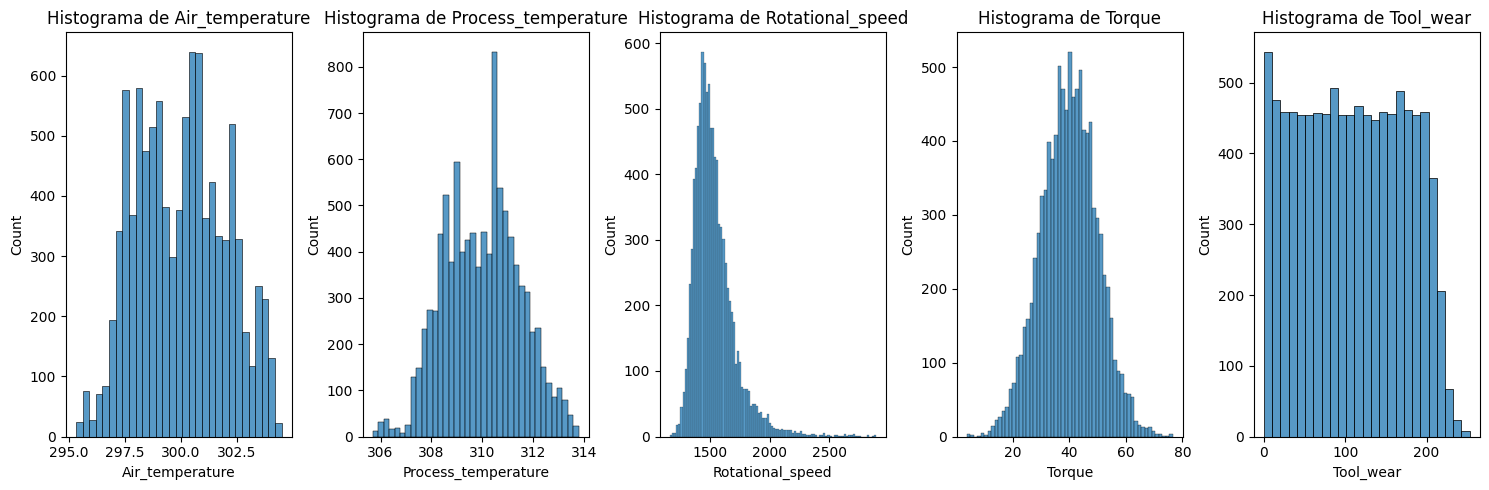

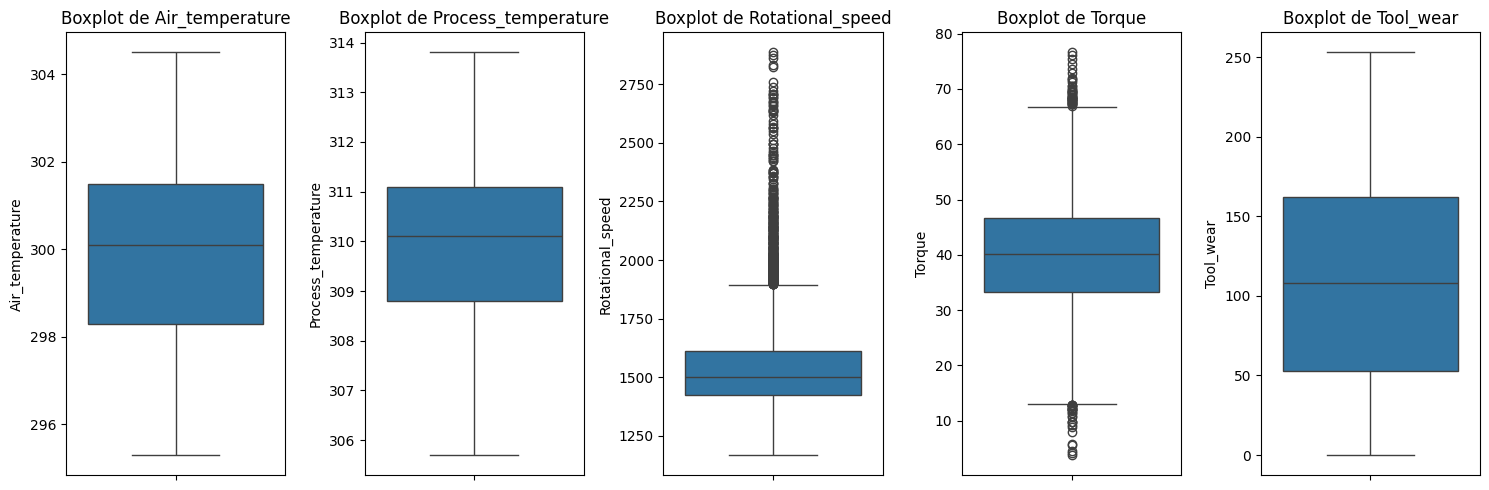

In [25]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot histograms 
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histograma de {feature}')

# Adjust subplot 
plt.tight_layout()

# Show histogram 
plt.show()

# Create the figure and axess
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot boxplot side by side
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature}')

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()

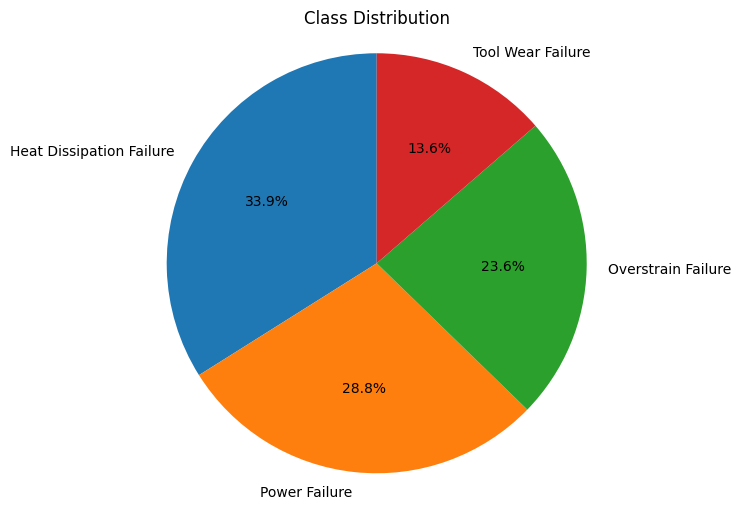

In [26]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]

# Verifique o balanceamento resultante
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)

# Plotar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Assegura que o gráfico seja desenhado como um círculo
plt.title('Class Distribution')
plt.show()

<Axes: >

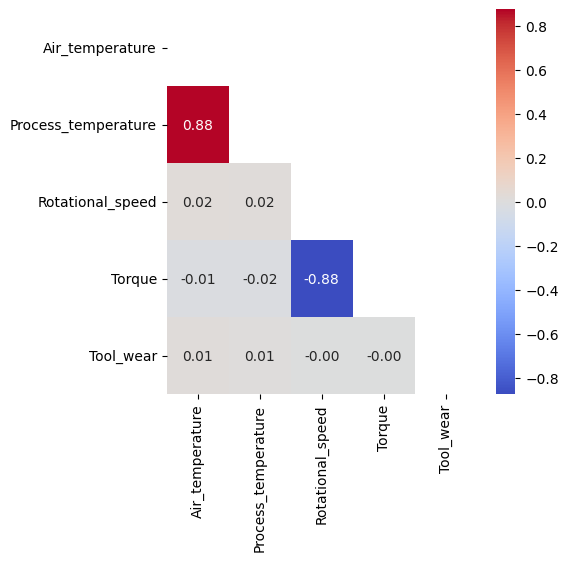

In [27]:
# Plot correlation of numeric values applying mask
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()
plt.figure(figsize = (5,5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")

In [28]:
# Create preprocessor ColumnTransformer to do OneHotEncoder for CATEGORIC_FEATURES and StandardScaler() for NUMERIC_FEATURES
# Define the pipelines for numeric and categorical transformations
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])
# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES)
])
# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Converting the transformed data back to a dataframe for easier visualization
# The transformed data will have new column names, especially for the one hot encoded categories
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0


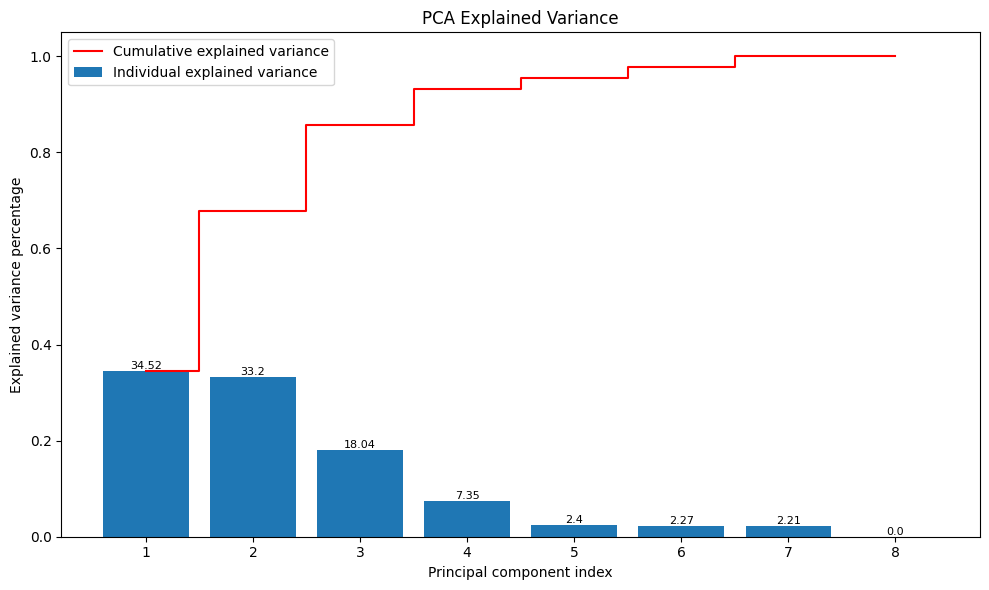

In [29]:
# Define PCA function
pca = PCA()
pca.fit(df_transformed)  # Assumindo que df_transformed é o seu DataFrame transformado

# PCA variance explained
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Number of components
n_pca_components = len(exp_var)

# Create the graphic
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Add labels in each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2), 
             va='bottom', ha='center', fontsize=8)

# Adjust others elements of the graphic
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

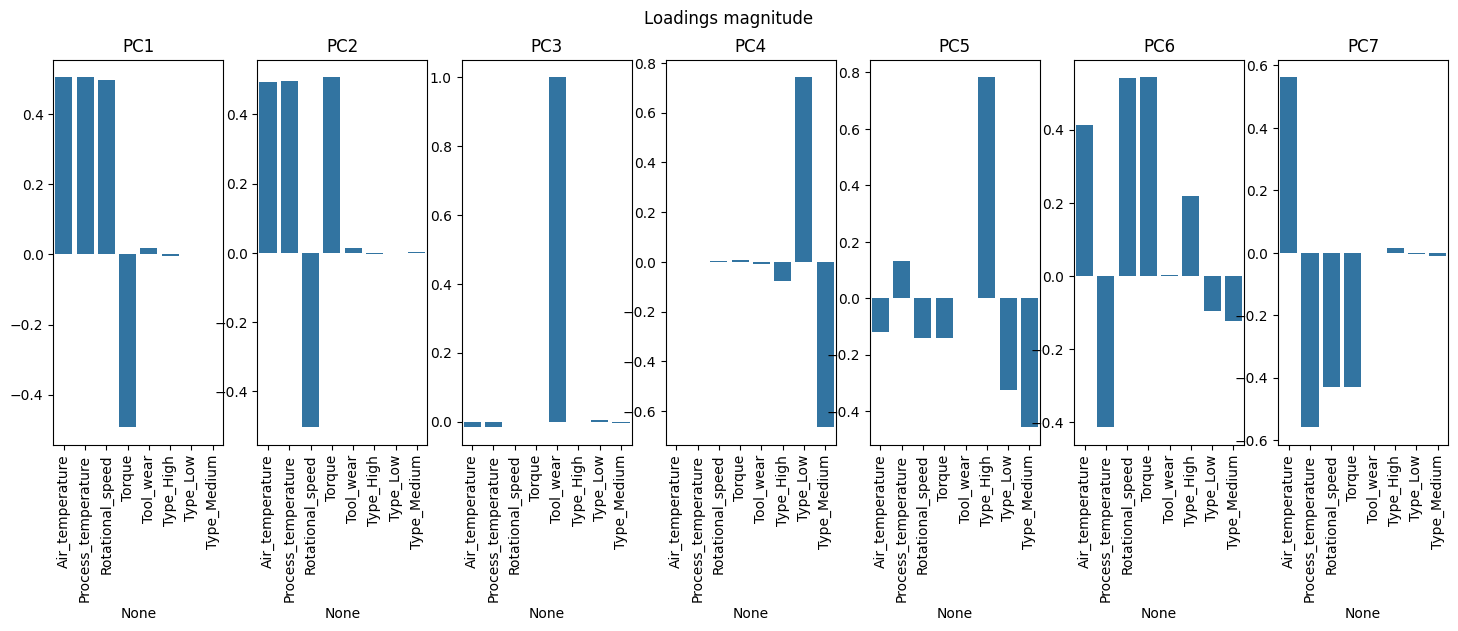

In [30]:
# PCA with 7 components to analyse what explain each component
pca7 = PCA(n_components=7)
X_pca7 = pd.DataFrame(data=pca7.fit_transform(df_transformed), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7'])

# Configure of the graphics
fig, axs = plt.subplots(ncols=7, figsize=(18,5))
fig.suptitle('Loadings magnitude')

all_features = NUMERIC_FEATURES + list(encoded_feature_names)  # Use encoded_feature_names do 
pca_loadings = pd.DataFrame(data=pca7.components_, columns=all_features)

#Plot the bar graphics
for j in range(7):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

In [ ]:
#Fix target imbalance


In [33]:
df_transformed = pd.concat([df_transformed, df['Failure_type']], axis=1)
df_transformed

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium,Failure_type
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0,No Failure
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0,No Failure
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0,No Failure
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0,No Failure
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0,No Failure
...,...,...,...,...,...,...,...,...,...
9968,-0.601495,-1.081162,0.362908,-1.051442,-1.475680,0.0,0.0,1.0,No Failure
9969,-0.551506,-1.081162,0.518981,-0.820665,-1.428545,1.0,0.0,0.0,No Failure
9970,-0.501517,-0.946356,0.591443,-0.660124,-1.349985,0.0,0.0,1.0,No Failure
9971,-0.501517,-0.878954,-0.729604,0.854982,-1.302849,1.0,0.0,0.0,No Failure


In [34]:
df_transformed.to_csv('C:/Users/mjkipsz2/OneDrive - The University of Manchester/Desktop/Pump failure/data/transformed_data.csv', index=False)